In [ ]:
import pandas as pd
import random
import torch
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.utils import class_weight
from google.colab import drive

In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


''

In [ ]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/"

In [ ]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


# **Extra Preprocessing**

---



In [ ]:
df = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")
df.head()

,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df = df.drop(columns = ["PATNO"], axis = 1)
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,614.150,1584.650,14.0825,174.325,270.285714,1
2,746.900,1256.775,10.9825,137.050,234.571429,1
3,612.020,1136.380,8.4880,109.100,231.875000,1
4,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df["P_TAU/T_TAU"] = df["P_TAU"]/df["T_TAU"]
df["P_TAU/ABETA42"] = df["P_TAU"]/df["ABETA42"]
df["T_TAU/ABETA42"] = df["T_TAU"]/df["ABETA42"]
df["ABETA42/A_SYN"] = df["ABETA42"]/df["A_SYN"]
df["P_TAU/A_SYN"] = df["P_TAU"]/df["A_SYN"]
df["T_TAU/A_SYN"] = df["T_TAU"]/df["A_SYN"]
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS,P_TAU/T_TAU,P_TAU/ABETA42,T_TAU/ABETA42,ABETA42/A_SYN,P_TAU/A_SYN,T_TAU/A_SYN
0,2571.400,3300.42,29.0060,338.960,293.142857,1,0.085574,0.011280,0.131819,0.779113,0.008789,0.102702
1,691.725,1259.80,9.3000,114.950,444.000000,1,0.080905,0.013445,0.166179,0.549075,0.007382,0.091245
2,793.775,1339.60,11.4000,136.225,250.333333,1,0.083685,0.014362,0.171617,0.592546,0.008510,0.101691
3,702.700,1731.70,16.0300,201.700,256.500000,1,0.079474,0.022812,0.287036,0.405786,0.009257,0.116475
4,548.625,793.85,8.6925,104.790,246.571429,1,0.082952,0.015844,0.191005,0.691094,0.010950,0.132002


In [ ]:
cols = ['ABETA42', 'A_SYN', 'P_TAU', 'T_TAU', 'URATE', "P_TAU/T_TAU",	"P_TAU/ABETA42", "T_TAU/ABETA42",	"ABETA42/A_SYN", "P_TAU/A_SYN", "T_TAU/A_SYN",'STATUS']
df = df[cols]
df.head()

,ABETA42,A_SYN,P_TAU,T_TAU,URATE,P_TAU/T_TAU,P_TAU/ABETA42,T_TAU/ABETA42,ABETA42/A_SYN,P_TAU/A_SYN,T_TAU/A_SYN,STATUS
0,2571.400,3300.42,29.0060,338.960,293.142857,0.085574,0.011280,0.131819,0.779113,0.008789,0.102702,1
1,691.725,1259.80,9.3000,114.950,444.000000,0.080905,0.013445,0.166179,0.549075,0.007382,0.091245,1
2,793.775,1339.60,11.4000,136.225,250.333333,0.083685,0.014362,0.171617,0.592546,0.008510,0.101691,1
3,702.700,1731.70,16.0300,201.700,256.500000,0.079474,0.022812,0.287036,0.405786,0.009257,0.116475,1
4,548.625,793.85,8.6925,104.790,246.571429,0.082952,0.015844,0.191005,0.691094,0.010950,0.132002,1


In [ ]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/Biospecimen/"

# **XGBoost Feature Selection**

---

In [ ]:
print(len(df))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

641


11
P_TAU/T_TAU      0.115735
A_SYN            0.110195
T_TAU            0.096917
URATE            0.093837
ABETA42          0.093027
ABETA42/A_SYN    0.086130
T_TAU/A_SYN      0.085674
P_TAU/A_SYN      0.085190
T_TAU/ABETA42    0.084942
P_TAU            0.075176
P_TAU/ABETA42    0.073177
dtype: float32


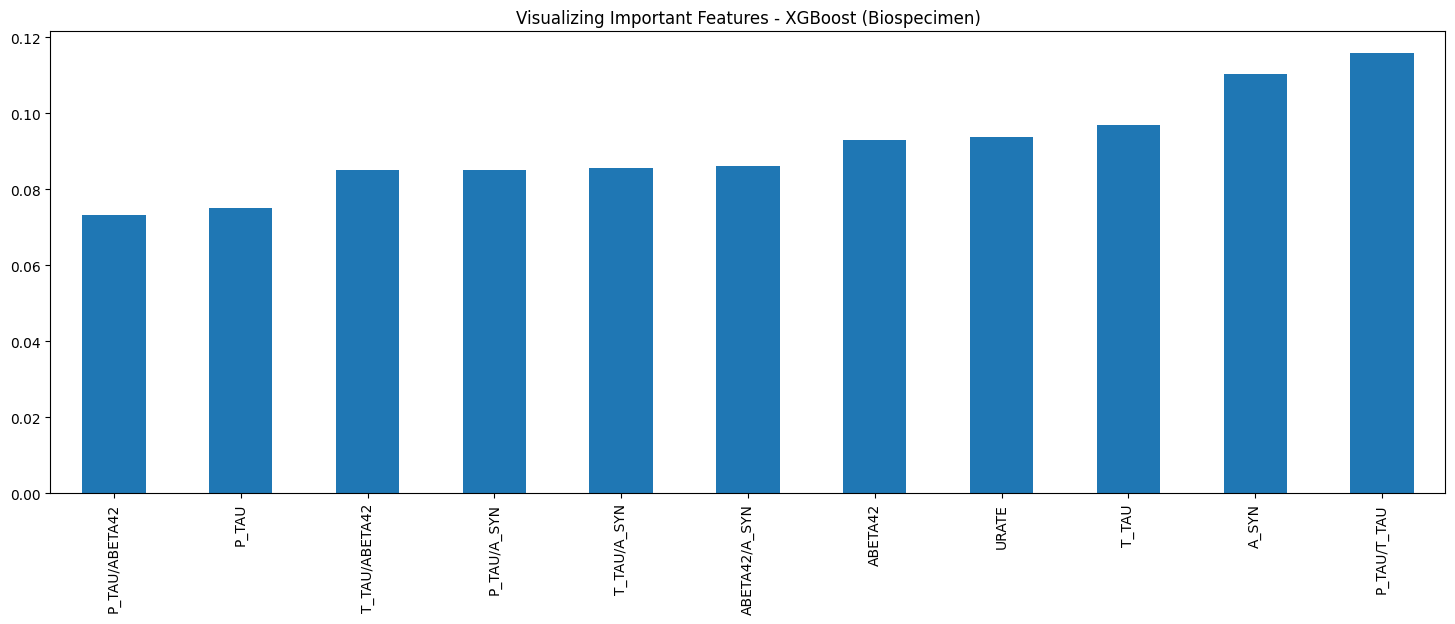

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost (Biospecimen)")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [ ]:
file = location + "feaSel_xgb_Biospec.txt"
with open(file, 'w') as file:
        for row in feaSel_xgb:
            s = "".join(map(str, row))
            file.write(s+'\n')

# **ML Models**

---



In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))

input_columns = 5
output_columns = 1

641


In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

512 129


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

In [ ]:
train_data_file = location + 'train_data.pkl'
test_data_file = location + 'test_data.pkl'

# Save training data
with open(train_data_file, 'wb') as f:
    pickle.dump((X, y), f)

# Save test data
with open(test_data_file, 'wb') as f:
    pickle.dump((X_test, y_test), f)

Train Data distribtuion:
STATUS
PD    362
HC    150
Name: count, dtype: int64


<Axes: title={'center': 'Train Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

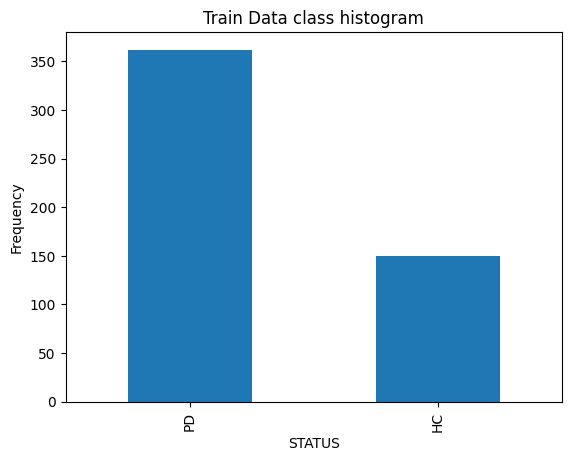

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

Test Data distribtuion:
STATUS
PD    94
HC    35
Name: count, dtype: int64


<Axes: title={'center': 'Test Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

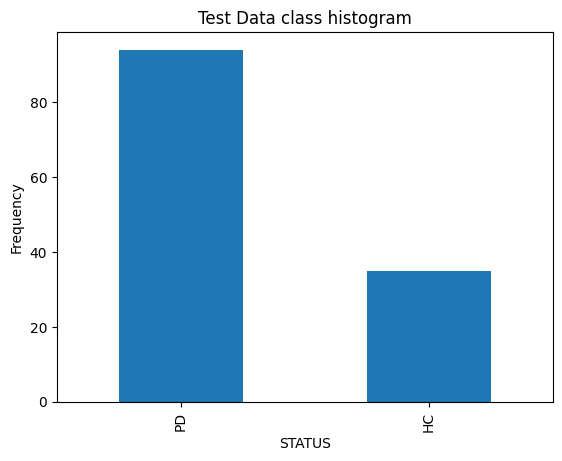

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

In [ ]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    f1_neg = f1_score(y_true, y_pred, pos_label=0)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    return (f1_neg + f1_pos) / 2

custom_scorer = make_scorer(custom_scorer)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.6,0.99,50)


# specify parameters and distributions to sample from
hp = {
    'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      'n_estimators': [10, 25],
      'max_features': [5, 10],
      'max_depth': [10, 50, None],
      'max_depth': np.arange(1, 5, 1),
      'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5],
      'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(10, 200, 10),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring=custom_scorer,
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_RF' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
565 fits failed out of a total of 1250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.7353061224489796,
                                     1: 0.26469387755102036},
                       criterion='entropy', max_depth=1, max_features=4,
                       n_estimators=180)
{'bootstrap': False,
 'class_weight': {0: 0.7353061224489796, 1: 0.26469387755102036},
 'criterion': 'entropy',
 'max_depth': 1,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 180,
 'warm_start': False}

Saving model



AUC-ROC =  0.6466565349544073
AUC-PR =  0.8017446711490138
F1 score =  0.7160493827160493
Precision =  0.8529411764705882
Recall =  0.6170212765957447
              precision    recall  f1-score   support

           0       0.41      0.71      0.52        35
           1       0.85      0.62      0.72        94

    accuracy                           0.64       129
   macro avg       0.63      0.67      0.62       129
weighted avg       0.73      0.64      0.66       129



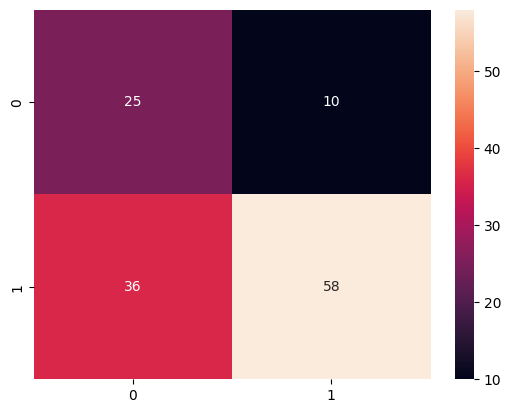

In [ ]:
# load the model from disk
filename = location + 'biospec_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf_rf.predict(X_test)
y_pred_proba = clf_rf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

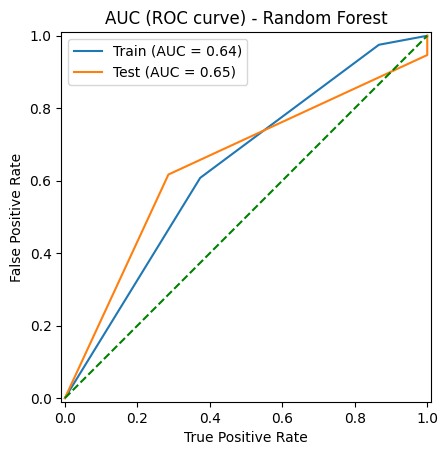

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(clf_rf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=50)}
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring=custom_scorer,
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_GNB' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GaussianNB(var_smoothing=0.12067926406393285)
{'var_smoothing': 0.12067926406393285}

Saving model



AUC-ROC =  0.6343465045592704
AUC-PR =  0.8260744734622512
F1 score =  0.8133971291866029
Precision =  0.7391304347826086
Recall =  0.9042553191489362
              precision    recall  f1-score   support

           0       0.36      0.14      0.20        35
           1       0.74      0.90      0.81        94

    accuracy                           0.70       129
   macro avg       0.55      0.52      0.51       129
weighted avg       0.64      0.70      0.65       129



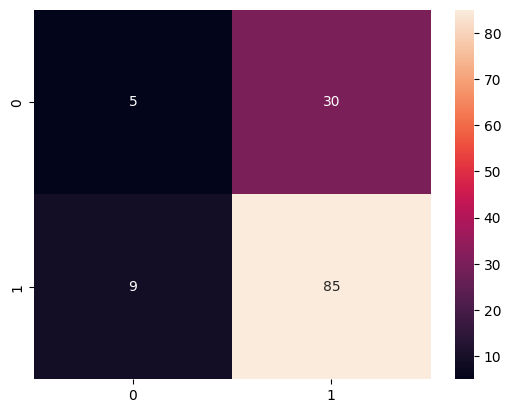

In [ ]:
# load the model from disk
filename = location + 'biospec_GNB' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf_gnb.predict(X_test)
y_pred_proba = clf_gnb.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

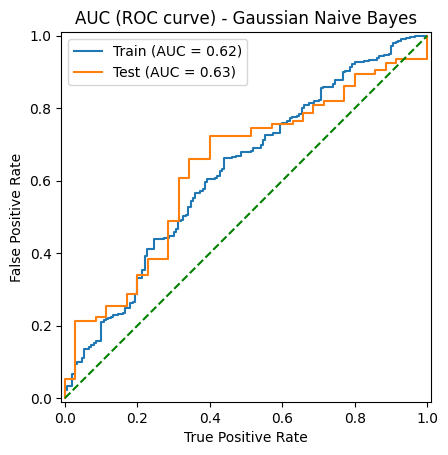

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(clf_gnb, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC(probability=True, random_state=42)

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      # 'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring=custom_scorer,
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_SVM' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
SVC(C=100, class_weight={0: 0.7273469387755102, 1: 0.27265306122448985},
    gamma='auto', kernel='poly', probability=True, random_state=42,
    shrinking=False)
{'C': 100,
 'class_weight': {0: 0.7273469387755102, 1: 0.27265306122448985},
 'gamma': 'auto',
 'kernel': 'poly',
 'shrinking': False}

Saving model



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

AUC-ROC =  0.5361702127659574
AUC-PR =  0.855409113400207
F1 score =  0.803921568627451
Precision =  0.7454545454545455
Recall =  0.8723404255319149
              precision    recall  f1-score   support

           0       0.37      0.20      0.26        35
           1       0.75      0.87      0.80        94

    accuracy                           0.69       129
   macro avg       0.56      0.54      0.53       129
weighted avg       0.64      0.69      0.66       129



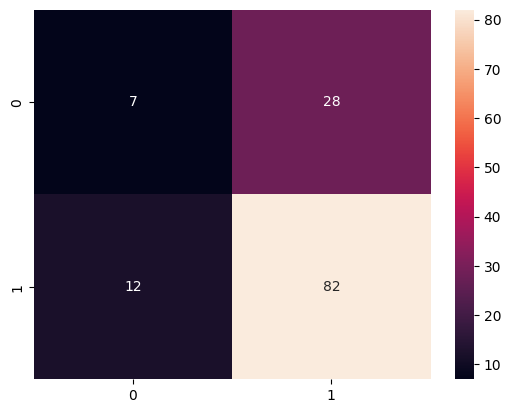

In [ ]:
# load the model from disk
filename = location + 'biospec_SVM' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf_svm.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=100, class_weight={0: 0.7273469387755102, 1: 0.27265306122448985},
    gamma='auto', kernel='poly', probability=True, random_state=42,
    shrinking=False)


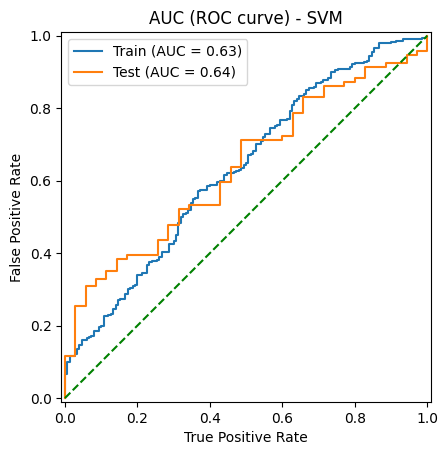

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_svm)

for i in range(2):
  RocCurveDisplay.from_estimator(clf_svm, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],  # elasticnet only with saga
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'],  # Correct solvers
    'class_weight': [{0: x, 1: 1.0 - x} for x in np.linspace(0.1, 0.9, 9)],  # Adjusted weight distribution
    'multi_class': ['ovr'],  # ovr for binary classifiers with liblinear
    'warm_start': [True, False],
    'l1_ratio': np.arange(0, 1.1, 0.1),  # Only relevant for elasticnet
    'random_state': [81]
}

# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring=custom_scorer,
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'biospec_logReg' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
3570 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

LogisticRegression(C=0.1,
                   class_weight={0: 0.7000000000000001, 1: 0.29999999999999993},
                   l1_ratio=0.5, multi_class='ovr', random_state=81,
                   solver='liblinear', warm_start=True)
{'C': 0.1,
 'class_weight': {0: 0.7000000000000001, 1: 0.29999999999999993},
 'l1_ratio': 0.5,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': True}

Saving model



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


AUC-ROC =  0.6507598784194529
AUC-PR =  0.8471403439050604
F1 score =  0.7582417582417582
Precision =  0.7840909090909091
Recall =  0.7340425531914894
              precision    recall  f1-score   support

           0       0.39      0.46      0.42        35
           1       0.78      0.73      0.76        94

    accuracy                           0.66       129
   macro avg       0.59      0.60      0.59       129
weighted avg       0.68      0.66      0.67       129



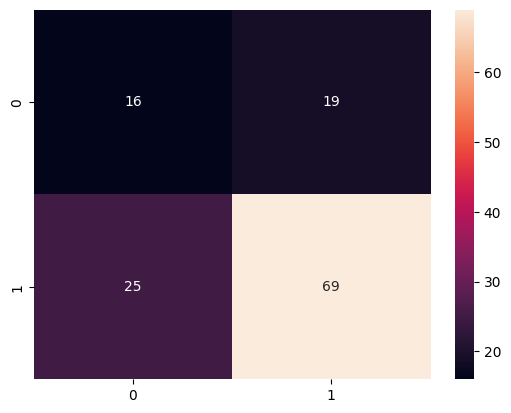

In [ ]:
# load the model from disk
filename = location + 'biospec_logReg' + '.sav'
clf_logReg = pickle.load(open(filename, 'rb'))

y_pred = clf_logReg.predict(X_test)
y_pred_proba = clf_logReg.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=0.1,
                   class_weight={0: 0.7000000000000001, 1: 0.29999999999999993},
                   l1_ratio=0.5, multi_class='ovr', random_state=81,
                   solver='liblinear', warm_start=True)


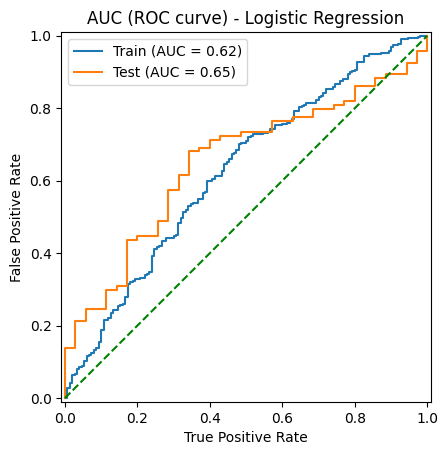

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_logReg)

for i in range(2):
  RocCurveDisplay.from_estimator(clf_logReg, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **LightGBM**

---

In [ ]:
clf = LGBMClassifier()

# # Parameters used by our current model
# print('Parameters initial\n')
# pprint(clf.get_params())

# Setting the range for class weights
weights = np.linspace(0.6, 0.99, 50)

# Specify parameters and distributions to sample from
hp = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': np.arange(50, 500, 50),
    'min_child_samples': np.arange(20, 200, 20),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'reg_alpha': np.logspace(-4, 1, 20),
    'reg_lambda': np.logspace(-4, 1, 20),
    'class_weight': [{0: x, 1: 1.0 - x} for x in weights]
}

# # Print the parameter space
# pprint(hp)

# Run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(),
                                   verbose=2,
                                   scoring=custom_scorer,
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model using the training sets
random_search.fit(X, y)

# Display the best model and its parameters
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

# Save the best estimator
clf = random_search.best_estimator_

clf.fit(X, y)

filename = location + 'biospec_lgbm' + '.sav'
pickle.dump(clf, open(filename, 'wb'))



Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[LightGBM] [Info] Number of positive: 362, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592659 -> initscore=0.374970
[LightGBM] [Info] Start training from score 0.374970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

AUC-ROC =  0.6028875379939208
AUC-PR =  0.8217963196328626
F1 score =  0.7446808510638298
Precision =  0.7446808510638298
Recall =  0.7446808510638298
              precision    recall  f1-score   support

           0       0.31      0.31      0.31        35
           1       0.74      0.74      0.74        94

    accuracy                           0.63       129
   macro avg       0.53      0.53      0.53       129
weighted avg       0.63      0.63      0.63       129



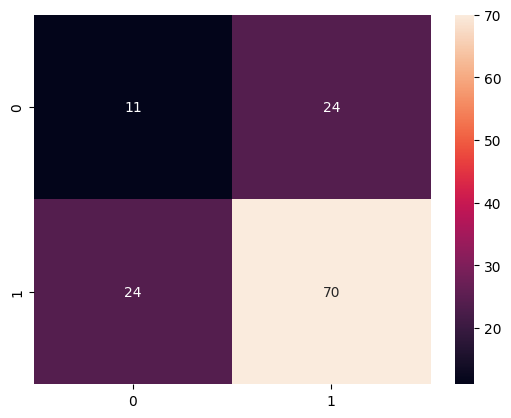

In [ ]:
# Load the model from disk
filename = location + 'biospec_lgbm' + '.sav'
clf_lgbm = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_lgbm.predict(X_test)
y_pred_proba = clf_lgbm.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - LightGBM")
plt.show()


LGBMClassifier(class_weight={0: 0.6238775510204081, 1: 0.3761224489795919},
               colsample_bytree=0.6666666666666666,
               learning_rate=0.06999999999999999, max_depth=4,
               min_child_samples=40, num_leaves=20,
               reg_alpha=0.14384498882876628, reg_lambda=0.0001,
               subsample=0.6111111111111112)


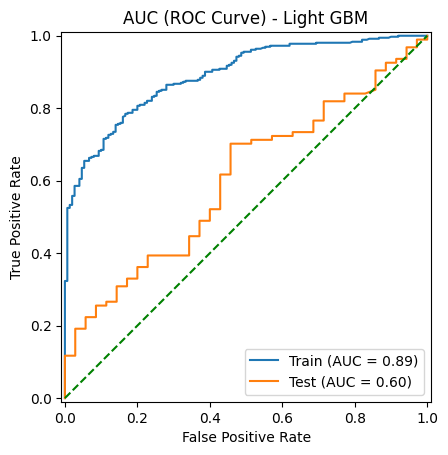

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_lgbm)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_lgbm, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Light GBM")
plt.show()

## **NN**

---

In [ ]:
clf = MLPClassifier(max_iter=500, random_state=42)


param_dist = {
    'hidden_layer_sizes': [(np.random.randint(50, 200),) * np.random.randint(1, 4) for _ in range(10)],  # Randomly select layer sizes and depths
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-5, 3, num=8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': np.logspace(-4, 0, num=5),
    'batch_size': [32, 64, 128, 256],
    'early_stopping': [True],
    'n_iter_no_change': [5, 10, 15, 20],
    'momentum': np.linspace(0.5, 0.95, num=5)
}


print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=StratifiedKFold(n_splits=5),
    verbose=5,
    scoring=make_scorer(custom_scorer),
    return_train_score=True,
    n_jobs=n_jobs_val,
    random_state=42
)

random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

clf.fit(X,y)

# Save the best model to disk

print("\nSaving model\n")

filename = location + 'biospec_mlp' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 751, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/loc

MLPClassifier(activation='tanh', alpha=5.179474679231202, batch_size=32,
              early_stopping=True, hidden_layer_sizes=(187, 187),
              learning_rate='adaptive', learning_rate_init=0.0001, max_iter=500,
              momentum=0.5, random_state=42, solver='sgd')
{'activation': 'tanh',
 'alpha': 5.179474679231202,
 'batch_size': 32,
 'early_stopping': True,
 'hidden_layer_sizes': (187, 187),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.0001,
 'momentum': 0.5,
 'n_iter_no_change': 10,
 'solver': 'sgd'}

Saving model


Saving model



AUC-ROC =  0.6337386018237081
AUC-PR =  0.8473417305116604
F1 score =  0.784688995215311
Precision =  0.7130434782608696
Recall =  0.8723404255319149
              precision    recall  f1-score   support

           0       0.14      0.06      0.08        35
           1       0.71      0.87      0.78        94

    accuracy                           0.65       129
   macro avg       0.43      0.46      0.43       129
weighted avg       0.56      0.65      0.59       129



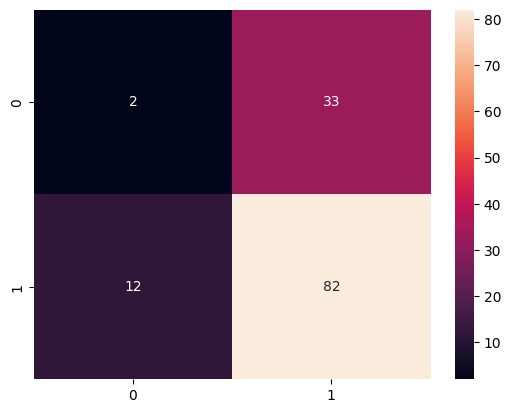

In [ ]:
# Load the model from disk
filename = location + 'biospec_mlp' + '.sav'
clf_mlp = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_mlp.predict(X_test)
y_pred_proba = clf_mlp.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - LightGBM")
plt.show()


MLPClassifier(activation='tanh', alpha=5.179474679231202, batch_size=32,
              early_stopping=True, hidden_layer_sizes=(187, 187),
              learning_rate='adaptive', learning_rate_init=0.0001, max_iter=500,
              momentum=0.5, random_state=42, solver='sgd')


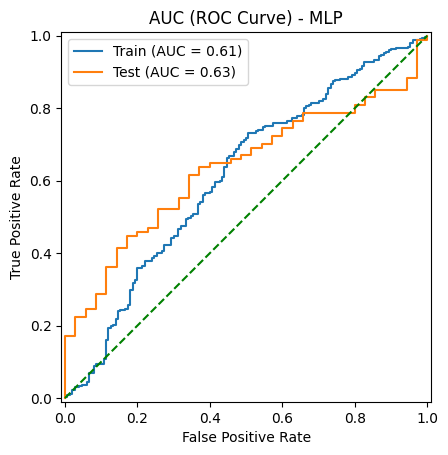

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_mlp)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_mlp, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - MLP")
plt.show()

NN with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
clf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(max_iter=500, random_state=42))
])

# Define the hyperparameter search space
param_dist = {
    'mlp__hidden_layer_sizes': [(np.random.randint(50, 200),) * np.random.randint(1, 4) for _ in range(10)],  # Randomly select layer sizes and depths
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': np.logspace(-5, 3, num=8),
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__learning_rate_init': np.logspace(-4, 0, num=5),
    'mlp__batch_size': [32, 64, 128, 256],
    'mlp__early_stopping': [True],
    'mlp__n_iter_no_change': [5, 10, 15, 20],
    'mlp__momentum': np.linspace(0.5, 0.95, num=5),
    'smote__sampling_strategy': [0.5, 0.75, 1.0]
}

# Perform RandomizedSearchCV for hyperparameter tuning
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=StratifiedKFold(n_splits=5),
    verbose=5,
    scoring=custom_scorer,
    return_train_score=True,
    n_jobs=n_jobs_val,
    random_state=42
)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

clf.fit(X,y)

# Save the best model to disk

print("\nSaving model\n")

filename = location + 'biospec_mlp_smote' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local/lib/

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('mlp',
                 MLPClassifier(alpha=0.026826957952797246, batch_size=128,
                               early_stopping=True,
                               hidden_layer_sizes=(60, 60, 60),
                               learning_rate='adaptive', max_iter=500,
                               momentum=0.5, n_iter_no_change=5,
                               random_state=42))])
{'mlp__activation': 'relu',
 'mlp__alpha': 0.026826957952797246,
 'mlp__batch_size': 128,
 'mlp__early_stopping': True,
 'mlp__hidden_layer_sizes': (60, 60, 60),
 'mlp__learning_rate': 'adaptive',
 'mlp__learning_rate_init': 0.001,
 'mlp__momentum': 0.5,
 'mlp__n_iter_no_change': 5,
 'mlp__solver': 'adam',
 'smote__sampling_strategy': 1.0}

Saving model


Saving model



AUC-ROC =  0.648936170212766
AUC-PR =  0.8421537699084024
F1 score =  0.75
Precision =  0.8048780487804879
Recall =  0.7021276595744681
              precision    recall  f1-score   support

           0       0.40      0.54      0.46        35
           1       0.80      0.70      0.75        94

    accuracy                           0.66       129
   macro avg       0.60      0.62      0.61       129
weighted avg       0.70      0.66      0.67       129



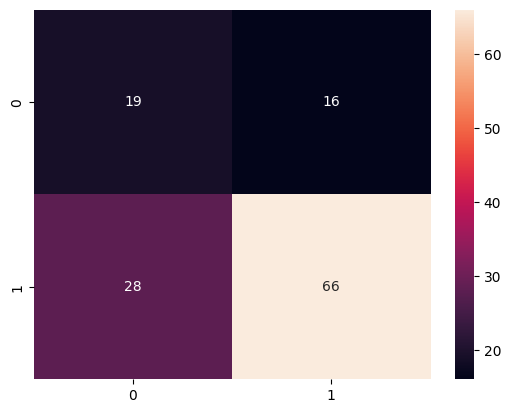

In [ ]:
# Load the model from disk
filename = location + 'biospec_mlp_smote' + '.sav'
clf_mlp_smote = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_mlp_smote.predict(X_test)
y_pred_proba = clf_mlp_smote.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - MLP with SMOTE")
plt.show()


Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('mlp',
                 MLPClassifier(alpha=0.026826957952797246, batch_size=128,
                               early_stopping=True,
                               hidden_layer_sizes=(60, 60, 60),
                               learning_rate='adaptive', max_iter=500,
                               momentum=0.5, n_iter_no_change=5,
                               random_state=42))])


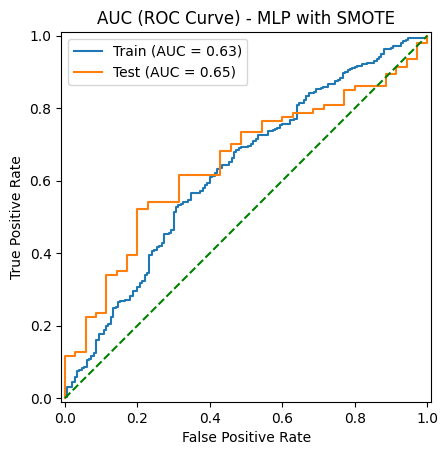

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_mlp_smote)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_mlp_smote, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - MLP with SMOTE")
plt.show()

# **Training the Ensemble Model**

---



In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
clf_rf = pickle.load(open(location + 'biospec_RF.sav', 'rb'))
clf_gnb = pickle.load(open(location + 'biospec_GNB.sav', 'rb'))
clf_svm = pickle.load(open(location + 'biospec_SVM.sav', 'rb'))
clf_logReg = pickle.load(open(location + 'biospec_logReg.sav', 'rb'))
clf_lgbm = pickle.load(open(location + 'biospec_lgbm.sav', 'rb'))
clf_mlp = pickle.load(open(location + 'biospec_mlp.sav', 'rb'))
clf_mlp_smote = pickle.load(open(location + 'biospec_mlp_smote.sav', 'rb'))


In [ ]:
clf = VotingClassifier(
    estimators=[
        ('rf', clf_rf),
        ('gnb', clf_gnb),
        ('svm', clf_svm),
        ('logReg', clf_logReg),
        ('lgbm', clf_lgbm),
        ('mlp', clf_mlp),
        ('mlp_smote', clf_mlp_smote)
    ],
    voting='soft'
)

hp = {
    'voting': ['hard', 'soft'],
    'flatten_transform': [True, False]
}

# Run randomized search
print("\nStarting randomized search for Ensemble\n")
n_iter_search = 100
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=5,
                                   scoring=custom_scorer,
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model
random_search.fit(X, y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving ensemble model\n")

clf = random_search.best_estimator_

# Train the model using the entire dataset
clf.fit(X, y)

# Save the model to disk
filename = location + 'biospec_Ensemble.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search for Ensemble

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 362, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592659 -> initscore=0.374970
[LightGBM] [Info] Start training from score 0.374970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 362, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.592659 -> initscore=0.374970
[LightGBM] [Info] Start training from score 0.374970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

AUC-ROC =  0.6829787234042553
AUC-PR =  0.8741944675450521
F1 score =  0.8095238095238095
Precision =  0.7327586206896551
Recall =  0.9042553191489362
              precision    recall  f1-score   support

           0       0.31      0.11      0.17        35
           1       0.73      0.90      0.81        94

    accuracy                           0.69       129
   macro avg       0.52      0.51      0.49       129
weighted avg       0.62      0.69      0.64       129



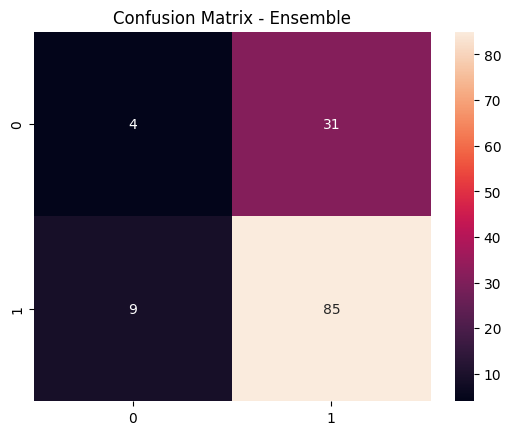

In [ ]:
# Load the model from disk
filename = location + 'biospec_Ensemble.sav'
clf_ensemble = pickle.load(open(filename, 'rb'))

# Make predictions
y_pred = clf_ensemble.predict(X_test)
y_pred_proba = clf_ensemble.predict_proba(X_test)[:, 1]

# Print performance metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Ensemble")
plt.show()


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight={0: 0.7353061224489796,
                                                                   1: 0.26469387755102036},
                                                     criterion='entropy',
                                                     max_depth=1,
                                                     max_features=4,
                                                     n_estimators=180)),
                             ('gnb',
                              GaussianNB(var_smoothing=0.12067926406393285)),
                             ('svm',
                              SVC(C=100,
                                  class_weight={0: 0.7273469387755102,
                                                1: 0.27265306122448985},
                                  gamma='auto', kernel='po...
                               

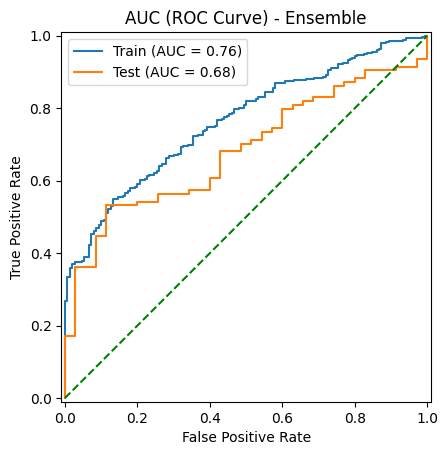

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_ensemble)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_ensemble, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Ensemble")
plt.show()

## **ROC Curve**

---

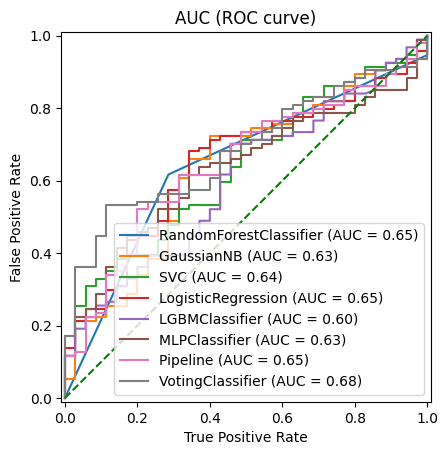

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_lgbm, clf_mlp, clf_mlp_smote, clf_ensemble]

for i in classifiers:
    RocCurveDisplay.from_estimator(i, X_test, y_test, ax=ax)
# plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

# **NN**

---



#### **Defining Train_data, Val_data and Test data**

---



In [ ]:
# dataset = df.values

# train_length = int(0.6*len(df))
# val_length = int(0.2*len(df))
# test_length = int(0.2*len(df))+1

# X = dataset[:train_length,0:input_columns]
# y = dataset[:train_length, -1].reshape(train_length, 1)

# X_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
# y_valid = dataset[train_length: (train_length + val_length), -1].reshape(val_length, 1)

# X_test = dataset[(train_length + val_length): (train_length + val_length + test_length), 0:input_columns]
# y_test = dataset[(train_length + val_length): (train_length + val_length + test_length), -1].reshape(test_length, 1)

# # USING CLASS WEIGHTS
# # class_weights = dict(zip(np.unique(y.flatten()), class_weight.compute_class_weight('balanced', np.unique(y.flatten()), y.flatten())))

# scalarX = MinMaxScaler()
# scalarX.fit(X)

# X = scalarX.transform(X)
# X_valid = scalarX.transform(X_valid)
# X_test = scalarX.transform(X_test)

# print(len(X), len(X_valid), len(X_test))

384 128 129


Train Data distribtuion:
STATUS
PD    275
HC    109
Name: count, dtype: int64


<Axes: title={'center': 'Train Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

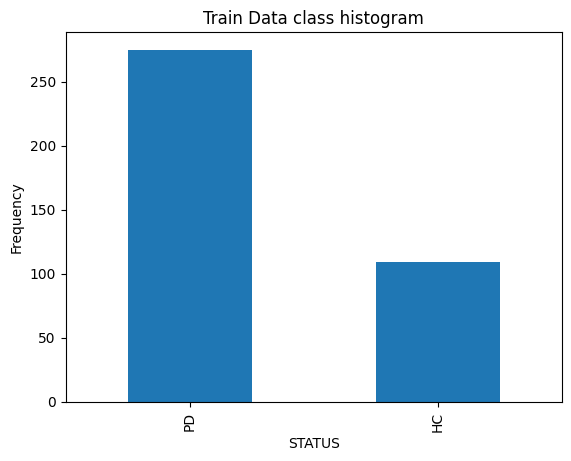

In [ ]:
# # Train data distribution
# count_classes = df.iloc[:train_length, -1].replace({0:"HC", 1:"PD"}).value_counts()
# print("Train Data distribtuion:")
# print(count_classes)
# plt.title("Train Data class histogram")
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# count_classes.plot(kind = 'bar')

Val Data distribtuion:
STATUS
PD    92
HC    36
Name: count, dtype: int64


<Axes: title={'center': 'Val Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

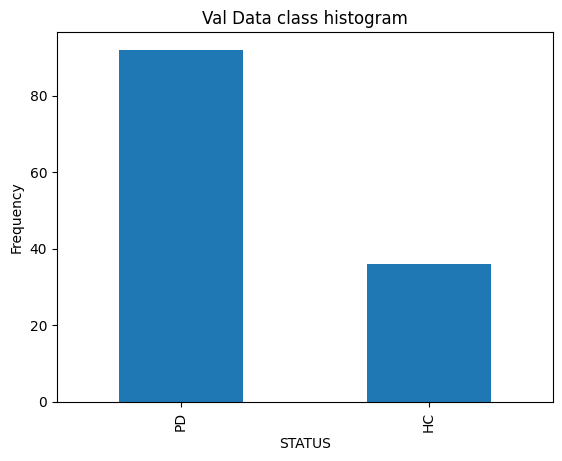

In [ ]:
# # Val data distribution
# count_classes = df.iloc[train_length: (train_length + val_length), -1].replace({0:"HC", 1:"PD"}).value_counts()
# print("Val Data distribtuion:")
# print(count_classes)
# plt.title("Val Data class histogram")
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# count_classes.plot(kind = 'bar')

Test Data distribtuion:
STATUS
1    89
0    40
Name: count, dtype: int64


<Axes: title={'center': 'Test Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

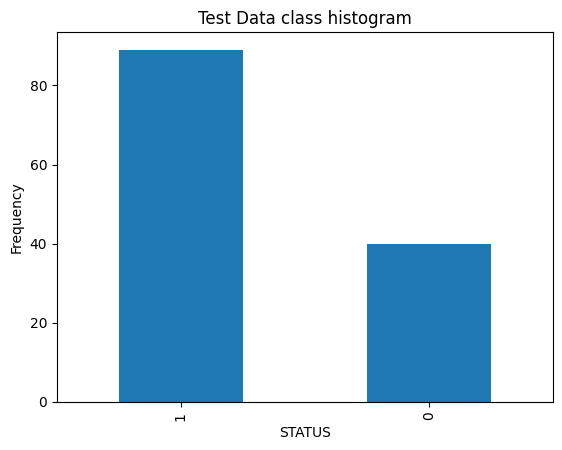

In [ ]:
# # Test data distribution
# count_classes = df.iloc[(train_length + val_length): (train_length + val_length + test_length), -1].value_counts()
# print("Test Data distribtuion:")
# print(count_classes)
# plt.title("Test Data class histogram")
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# count_classes.plot(kind = 'bar')

# **Training the Model**

---



In [ ]:
# Define the model and hyperparameter search space
mlp = MLPClassifier(max_iter=200, random_state=42)

param_dist = {
    'hidden_layer_sizes': [(np.random.randint(50, 200),) * np.random.randint(1, 4) for _ in range(10)],  # Randomly select layer sizes and depths
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-5, 3, num=8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': np.logspace(-4, 0, num=5),
    'batch_size': [32, 64, 128, 256],
    'early_stopping': [True],
    'n_iter_no_change': [5, 10, 15],
    'momentum': np.linspace(0.5, 0.95, num=5),
}

# param_dist = {
#     'hidden_layer_sizes': [(x,) * y for x in range(10, 101, 10) for y in range(1, 5)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': uniform(0.0001, 0.001),
#     'learning_rate': ['constant', 'adaptive'],
#     'learning_rate_init': uniform(0.001, 0.01),
#     'max_iter': randint(100, 500),
#     'early_stopping': [True, False],
#     'validation_fraction': uniform(0.1, 0.2),
#     'beta_1': uniform(0.8, 0.999),
#     'beta_2': uniform(0.9, 0.9999),
#     'epsilon': uniform(1e-8, 1e-7),
#     'n_iter_no_change': randint(5, 20),
#     'momentum': uniform(0.8, 0.99),
#     'nesterovs_momentum': [True, False],
#     'dropout': uniform(0, 0.5)
# }

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, scoring='accuracy',
                                   n_jobs=-1, cv=5, verbose=1, random_state=42)

# Fit model with random search
random_search.fit(X, y)

# Best model from RandomizedSearchCV
best_model = random_search.best_estimator_
print("Best model parameters:", random_search.best_params_)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


### **Save Model**

In [ ]:
print("\nSaving the best model and scaler...")
joblib.dump(best_model, model_save_path)
joblib.dump(scaler, scaler_save_path)
print(f"Model saved to {model_save_path}")
print(f"Scaler saved to {scaler_save_path}")


Saving model
Saved model as json
Saved model weights


### **Load Model**

In [ ]:
# Load the model and scaler for future use
print("\nLoading the saved model and scaler...")
model = joblib.load(model_save_path)
scaler = joblib.load(scaler_save_path)
print("Model and scaler loaded successfully.")

# **Model Evaluation**

---



Train AUC-ROC = 0.63
Validation AUC-ROC = 0.52
Test AUC-ROC = 0.62


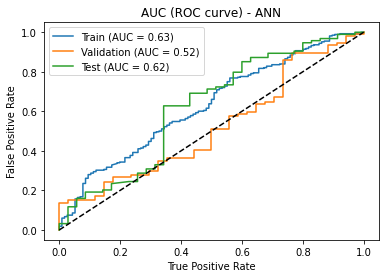

In [ ]:
def evaluate_model(model, X, y, dataset_name):
    pred = model.predict_proba(X)[:, 1]  # Predict probabilities for ROC AUC
    fpr, tpr, _ = roc_curve(y, pred)
    auc_value = auc(fpr, tpr).round(2)
    print(f"{dataset_name} AUC-ROC = {auc_value}")

    y_pred = np.where(pred > 0.5, 1, 0)
    print(f"Confusion Matrix for {dataset_name}:")
    print(confusion_matrix(y, y_pred))
    print(f"Classification Report for {dataset_name}:")
    print(classification_report(y, y_pred))

    return fpr, tpr, auc_value

# Evaluate the loaded model
fpr_train, tpr_train, auc_train = evaluate_model(model, X, y, "Train")
fpr_val, tpr_val, auc_val = evaluate_model(model, X_valid, y_valid, "Validation")
fpr_test, tpr_test, auc_test = evaluate_model(model, X_test, y_test, "Test")

# Plotting ROC curves for train, validation, and test sets
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC (ROC Curve) - Neural Network with RandomizedSearchCV')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def check_metrics(model, testX, testY):

  pred = model.predict(testX)
  y_pred = np.where(pred > 0.5, 1, 0)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(testY, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  print(classification_report(testY, y_pred))

In [ ]:
check_metrics(model, X_valid, y_valid)

##############  Confusion Matrix  ##############

[[17 17]
 [53 41]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.24      0.50      0.33        34
         1.0       0.71      0.44      0.54        94

    accuracy                           0.45       128
   macro avg       0.47      0.47      0.43       128
weighted avg       0.58      0.45      0.48       128



In [ ]:
check_metrics(model, X, y)

##############  Confusion Matrix  ##############

[[ 60  56]
 [105 163]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.36      0.52      0.43       116
         1.0       0.74      0.61      0.67       268

    accuracy                           0.58       384
   macro avg       0.55      0.56      0.55       384
weighted avg       0.63      0.58      0.60       384



In [ ]:
check_metrics(model, X_test, y_test)

##############  Confusion Matrix  ##############

[[20 15]
 [35 59]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.36      0.57      0.44        35
         1.0       0.80      0.63      0.70        94

    accuracy                           0.61       129
   macro avg       0.58      0.60      0.57       129
weighted avg       0.68      0.61      0.63       129



In [ ]:
index = 2

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

[[0.34214024 0.27632735 0.07505419 0.14754164 0.13106796]]
PREDICTION BY MODEL: [0.45257032]
CLASS IS HC
TRUE VALUE: [1.]


# **Checking Correlations**

---



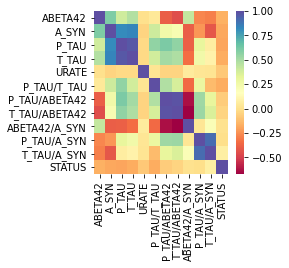

In [ ]:
plt.figure(figsize=(3,3))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
print("IMPORTANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1) > 0.1 or abs(corr2) > 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

print("REDUNDANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1)< 0.1 or abs(corr2) < 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

IMPORTANT FEATURES

ABETA42:		 Spearmans correlation: 0.136 Pearsons correlation: 0.150
A_SYN:		 Spearmans correlation: 0.166 Pearsons correlation: 0.145
P_TAU:		 Spearmans correlation: 0.151 Pearsons correlation: 0.162
T_TAU:		 Spearmans correlation: 0.127 Pearsons correlation: 0.140
P_TAU/T_TAU:		 Spearmans correlation: 0.176 Pearsons correlation: 0.160
T_TAU/ABETA42:		 Spearmans correlation: 0.100 Pearsons correlation: 0.025

REDUNDANT FEATURES

URATE:		 Spearmans correlation: 0.067 Pearsons correlation: 0.059
P_TAU/ABETA42:		 Spearmans correlation: 0.054 Pearsons correlation: 0.057
T_TAU/ABETA42:		 Spearmans correlation: 0.100 Pearsons correlation: 0.025
ABETA42/A_SYN:		 Spearmans correlation: 0.036 Pearsons correlation: 0.023
P_TAU/A_SYN:		 Spearmans correlation: 0.001 Pearsons correlation: 0.025
T_TAU/A_SYN:		 Spearmans correlation: 0.069 Pearsons correlation: 0.048

